## Start Analysis

In [2]:
import pandas as pd
df = pd.read_pickle("./mobileCarriers.pkl")
df.shape

(213859, 4)

In [3]:
df.head()

,screen_name,date_time,location,text
0,leila_fong,2019-10-23 23:57:59,"Illinois, USA","@ATTHelp I’m blocking, but then they change th..."
1,SnackEvangelist,2019-10-23 23:57:44,,@ATTHelp Just logged into my account and it’s ...
2,DeathboxTy,2019-10-23 23:54:34,,@ATTHelp can’t get my Visual Voicemail to work...
3,BLoLovesYou,2019-10-23 23:54:05,"San Antonio, TX",@ATTHelp You were charging me $150 for an outd...
4,ATTHelp,2019-10-23 23:53:02,,"@leila_fong Hey, Leila, we're here to help. Cl..."


## Pre-processing tweets

In [4]:
import re
from nltk.tokenize import TweetTokenizer
from nltk.corpus import stopwords
import time

start_time = time.time() 

tokenizer = TweetTokenizer()
tokenized_tweets = [tokenizer.tokenize(t) for t in df.text]
stop_words = stopwords.words("english")
stop_words.extend(["&amp;", "&gt;", "&lt;"])
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

clean_text = []
handles = []
hashtags = []
carrier = []
# tweet_len = []
for tweet in tokenized_tweets:
    thandles = []
    thashtags = []
    joined_words = " "
    words = [w.lower() for w in tweet if len(w)>2 and w not in stop_words]
    thandles = [w for w in words if re.search("^@\w+", w)]
    tlinks = [w for w in words if re.search("^https:\w+", w)]
    thashtags = [w for w in words if re.search("^#\w+", w)]
    words = [w for w in words if w.isalpha() and w not in thandles and w not in thashtags and w not in tlinks]
    words = [lemmatizer.lemmatize(w) for w in words]
    
    joined_words = joined_words.join(words)
    tlength = len(joined_words)
    handles.append(thandles)
    hashtags.append(thashtags)
    clean_text.append(joined_words)
#     tweet_len.append(tlength)
    

    
print('Elapsed clock time: ', (time.time() - start_time)/3600, ' seconds')

Elapsed clock time:  0.008540990286403233  seconds


In [5]:
df["clean_text"] = clean_text
df["handles"] = handles
df["hashtags"] = hashtags
df.head()

,screen_name,date_time,location,text,clean_text,handles,hashtags
0,leila_fong,2019-10-23 23:57:59,"Illinois, USA","@ATTHelp I’m blocking, but then they change th...",blocking change number one digit switch unknown,[@atthelp],[]
1,SnackEvangelist,2019-10-23 23:57:44,,@ATTHelp Just logged into my account and it’s ...,just logged account added how get rid,[@atthelp],[]
2,DeathboxTy,2019-10-23 23:54:34,,@ATTHelp can’t get my Visual Voicemail to work...,get visual voicemail work suggestion tried tip...,[@atthelp],[]
3,BLoLovesYou,2019-10-23 23:54:05,"San Antonio, TX",@ATTHelp You were charging me $150 for an outd...,you charging outdated unlimited plan switched ...,[@atthelp],[]
4,ATTHelp,2019-10-23 23:53:02,,"@leila_fong Hey, Leila, we're here to help. Cl...",hey leila help click learn protect unwanted call,[@leila_fong],[]


### Add sentiment columns

In [6]:
from textblob import TextBlob
polarity = [0.0]*len(df)
subjectivity = [0.5]*len(df)
sentiment = [""]*len(df)

for i in df.index:
    blob = TextBlob(df.clean_text[i])
    polarity[i] = blob.polarity
    subjectivity[i] = blob.subjectivity
    if polarity[i] > 0.0:
        sentiment[i] = "pos"
    elif polarity[i] < 0.0:
        sentiment[i] = "neg"
    else:
        sentiment[i] = "neu"

df["sentiment"]    = sentiment
df["polarity"]     = polarity
df["subjectivity"] = subjectivity

### Add "Carrier" column

In [7]:
# carrier keywords: 'tmobile', 'att', 'verizon'
# As long as a keyword appears in the user's tweet, 
# that tweet is considered to be in the description of that certain carrier.
# One tweet can describe more than one carrier.

carrier = []

for text in df[['screen_name','text']].values:
    screen_name = text[0].lower()
    twitter_text = text[1].lower()
    current_carrier = []
    if 'tmobile' in twitter_text or 'tmobile' in screen_name:
        current_carrier.append('tmobile')
    if 'att' in twitter_text or 'att' in screen_name:
        current_carrier.append('att')
    if 'verizon' in twitter_text or 'verizon' in screen_name:
        current_carrier.append('verizon')
#     if len(current_carrier) == 0:
#         current_carrier.append('None')
    carrier.append(' '.join(current_carrier))

df['carrier'] = carrier
        

In [8]:
df[['carrier','location','date_time','clean_text','sentiment']].head()

,carrier,location,date_time,clean_text,sentiment
0,att,"Illinois, USA",2019-10-23 23:57:59,blocking change number one digit switch unknown,neg
1,att,,2019-10-23 23:57:44,just logged account added how get rid,neu
2,att,,2019-10-23 23:54:34,get visual voicemail work suggestion tried tip...,neu
3,att,"San Antonio, TX",2019-10-23 23:54:05,you charging outdated unlimited plan switched ...,pos
4,att,,2019-10-23 23:53:02,hey leila help click learn protect unwanted call,neu


In [9]:
# Drop records that has null value in carrier culumn, which means that the tweet does not describe any carrier.

df = df[df.carrier != '']
df.shape

(171423, 11)

In [10]:
# get the counts of each carrier

c = df.carrier.value_counts()

In [12]:
# build a clean text for classifier, clf_text, which remove the links and keep the stop words

tokenized_tweets = [tokenizer.tokenize(t) for t in df.text]
clf_text = []
for tweet in tokenized_tweets:
    joined_words = " "
    words = [w.lower() for w in tweet if w.isalpha() or w[0]=='@']
    tlinks = [w for w in words if re.search("^https:\w+", w)]
    words = [w for w in words if  w not in tlinks]
    joined_words = joined_words.join(words)
    clf_text.append(joined_words)

df["clf_text"] = clf_text

In [13]:
df["clf_text"].head()

0    @atthelp i m blocking but then they change the...
1    @atthelp just logged into my account and it s ...
2    @atthelp can t get my visual voicemail to work...
3    @atthelp you were charging me for an outdated ...
4    @leila_fong hey leila here to help click here ...
Name: clf_text, dtype: object

In [14]:
df["text"].head()

0    @ATTHelp I’m blocking, but then they change th...
1    @ATTHelp Just logged into my account and it’s ...
2    @ATTHelp can’t get my Visual Voicemail to work...
3    @ATTHelp You were charging me $150 for an outd...
4    @leila_fong Hey, Leila, we're here to help. Cl...
Name: text, dtype: object

# Build 7 groups based on different Carrier

- att_df: tweets that only mentioned ATT
- ver_df: tweets that only mentioned Verizon
- tmo_df: tweets that only mentioned TMobile
- tmo_att_df: tweets that mentioned both TMobile and ATT
- att_ver_df: tweets that mentioned both ATT and Verizon
- tmo_ver_df: tweets that mentioned both TMobile and Verizon
- tmo_att_ver_df: tweets that mentioned all TMobile, ATT and Verizon


In [15]:
att_df = df[df['carrier']=='att'][['carrier','sentiment','polarity','text','clf_text']]
ver_df = df[df['carrier']=='verizon'][['carrier','sentiment','polarity','text','clf_text']]
tmo_df = df[df['carrier']=='tmobile'][['carrier','sentiment','polarity','text','clf_text']]

tmo_att_df = df[df['carrier']=='tmobile att'][['carrier','sentiment','polarity','text','clf_text']]
att_ver_df = df[df['carrier']=='att verizon'][['carrier','sentiment','polarity','text','clf_text']]
tmo_ver_df = df[df['carrier']=='tmobile verizon'][['carrier','sentiment','polarity','text','clf_text']]

tmo_att_ver_df = df[df['carrier']=='tmobile att verizon'][['carrier','sentiment','polarity','text','clf_text']]

In [16]:
# Randomly sample 50 records for each group to form a new database
# And try to make the ratio of pos to neg is 1

only_att_pos = att_df[att_df['sentiment']=='pos'].sample(25)
only_att_neg = att_df[att_df['sentiment']=='neg'].sample(25)
only_ver_pos = ver_df[ver_df['sentiment']=='pos'].sample(25)
only_ver_neg = ver_df[ver_df['sentiment']=='neg'].sample(25)
only_tmo_pos = tmo_df[tmo_df['sentiment']=='pos'].sample(25)
only_tmo_neg = tmo_df[tmo_df['sentiment']=='neg'].sample(25)

tmo_att = tmo_att_df.sample(50)
att_ver = att_ver_df.sample(50)
tmo_ver = tmo_ver_df.sample(50)

tmo_att_ver = tmo_att_ver_df.sample(50)


clf_corpus = pd.concat([only_att_pos,only_att_neg,only_ver_pos,only_ver_neg,only_tmo_pos,only_tmo_neg,tmo_att,att_ver,tmo_ver,tmo_att_ver] ,ignore_index=True)
clf_corpus.to_csv('clf_corpus.csv')

## Q1. Tweets count for per carrier and per group

In [19]:
c

att                    82395
verizon                47746
tmobile                31842
tmobile att             3400
att verizon             3164
tmobile verizon         2129
tmobile att verizon      747
Name: carrier, dtype: int64

In [20]:
att_df = df[df['carrier']=='att'][['date_time','location','clean_text','carrier', 'sentiment', 'polarity', 'subjectivity']]
verizon_df = df[df['carrier']=='verizon'][['date_time','location','clean_text','carrier', 'sentiment', 'polarity', 'subjectivity']]
tmobile_df = df[df['carrier']=='tmobile'][['date_time','location','clean_text','carrier', 'sentiment', 'polarity', 'subjectivity']]

tmobile_att_df = df[df['carrier']=='tmobile att'][['date_time','location','clean_text','carrier', 'sentiment', 'polarity', 'subjectivity']]
att_verizon_df = df[df['carrier']=='att verizon'][['date_time','location','clean_text','carrier', 'sentiment', 'polarity', 'subjectivity']]
tmobile_verizon_df = df[df['carrier']=='tmobile verizon'][['date_time','location','clean_text','carrier', 'sentiment', 'polarity', 'subjectivity']]

tmobile_att_verizon_df = df[df['carrier']=='tmobile att verizon'][['date_time','location','clean_text','carrier', 'sentiment', 'polarity', 'subjectivity']]

In [21]:
att = pd.concat([att_df,tmobile_att_df,att_verizon_df,tmobile_att_verizon_df], sort=False)
verizon = pd.concat([verizon_df,att_verizon_df,tmobile_verizon_df,tmobile_att_verizon_df], sort=False)
tmobile = pd.concat([tmobile_df,tmobile_att_df,tmobile_verizon_df,tmobile_att_verizon_df], sort=False)

In [22]:
import matplotlib.pyplot as plt

carrier_counts = []
carrier = ['ATT','Verizon','Tmobile']
for i in (att, verizon, tmobile):
    carrier_counts.append(len(i))

plt.figure(figsize=(15,5))
plt.subplot(121)
plt.bar(carrier, carrier_counts, color=['lightskyblue','moccasin','yellowgreen'])
plt.xlabel('carrier')
plt.ylabel('tweets counts')
plt.title('Tweets per carrier', fontsize=15)
plt.subplot(122)
group = ['ATT','Verizon','Tmobile', 'A&T', 'A&V','T&V','A&T&V']
plt.bar(group, c, alpha=0.6)
plt.xlabel('group')
plt.ylabel('tweets counts')
plt.title('Tweets per group', fontsize=15)
plt.show()

<Figure size 1500x500 with 2 Axes>

### Interpretation:
   As we can see from the graph, during the period from 2019-10-9 to 2019-10-23, ATT has the most tweets, and the carrier combination groups, tmo_att_df, att_ver_df, tmo_ver_df, tmo_att_ver_df, have much lower counts than single carrier group.
   We can initially conclude that customers wants to churn with a clear goal is the minority.

## Q2. Frequent description words for each carrier

In [23]:
from collections import Counter
import nltk

def get5CommonWords(text):
    words = nltk.tokenize.word_tokenize(text)
    stop_list = ['https','att','tmobile','verizon','the','hey','get']
    words = [w for w in words if w.isalpha() and w not in stop_list]
    most_occur = Counter(words).most_common(5)
    return most_occur
    # return ', '.join([word[0] for word in most_occur])

In [24]:
att_common_words = get5CommonWords(' '.join(att_df['clean_text'].values))
verizon_common_words = get5CommonWords(' '.join(verizon_df['clean_text'].values))
tmobile_common_words = get5CommonWords(' '.join(tmobile_df['clean_text'].values))

In [25]:
def printFrequentWords(carrier, common_words):
    word,count = zip(*common_words)
    print(carrier, ':',', '.join(word))

printFrequentWords('ATT', att_common_words)
printFrequentWords('Verizon', verizon_common_words)
printFrequentWords('Tmobile', tmobile_common_words)

ATT : comment, day, help, still, like
Verizon : customer, disney, free, service, year
Tmobile : customer, love, see, want, ticket


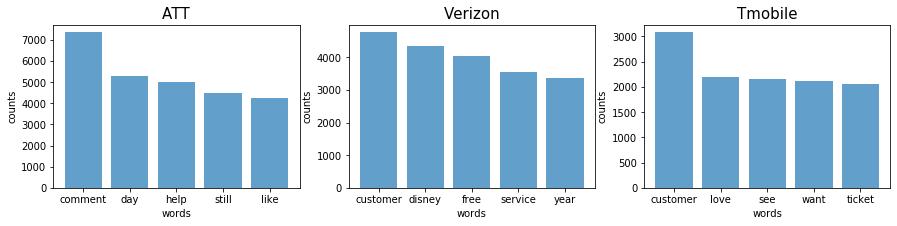

In [26]:
def frequentWordsPlot(common_words):
    word,count = zip(*common_words)
    plt.bar(word,count,alpha=0.7)

plt.figure(figsize=(15,3))
plt.subplot(131)
frequentWordsPlot(att_common_words)
plt.xlabel('words')
plt.ylabel('counts')
plt.title('ATT', fontsize=15)

plt.subplot(132)
frequentWordsPlot(verizon_common_words)
plt.xlabel('words')
plt.ylabel('counts')
plt.title('Verizon', fontsize=15)

plt.subplot(133)
frequentWordsPlot(tmobile_common_words)
plt.xlabel('words')
plt.ylabel('counts')
plt.title('Tmobile', fontsize=15)
plt.show()

## Q3. Mention times for each carrier per day

In [27]:
# Get the time series data
# att_df['date_time'].dt.year
# att_df['date_time'].dt.date
# att_df['date_time'].dt.dayofweek.value_counts()

In [28]:
def getDateCounts(df):
    date = df['date_time'].dt.date
    df['date'] = date
    size = df.groupby('date').size()
    return size

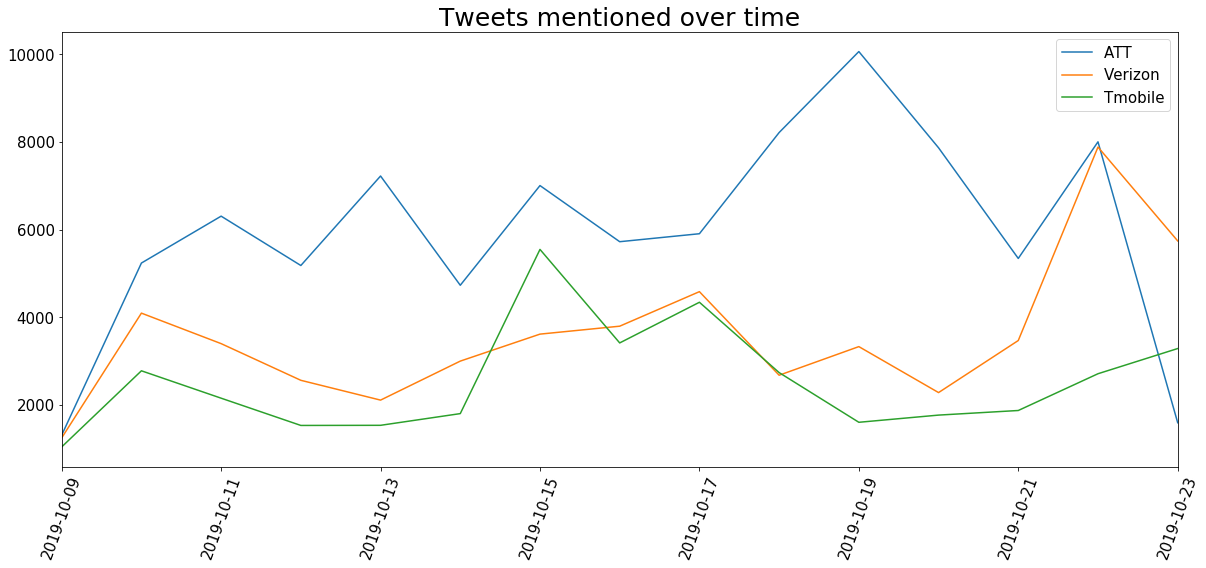

In [29]:
# att_df.groupby('date').head(1)
# att_df.groupby('date').describe()
import matplotlib.pyplot as plt

plt.figure(figsize=(20,8))
getDateCounts(att).plot(label='ATT')
getDateCounts(verizon).plot(label='Verizon')
getDateCounts(tmobile).plot(label='Tmobile')
plt.xticks(rotation=70, fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel('')
plt.legend(prop={'size':15})
plt.title('Tweets mentioned over time', fontsize=25)
plt.show()

## Q4. Sentiment Analysis for each carrier

### a. Polarity distribution for 3 carriers

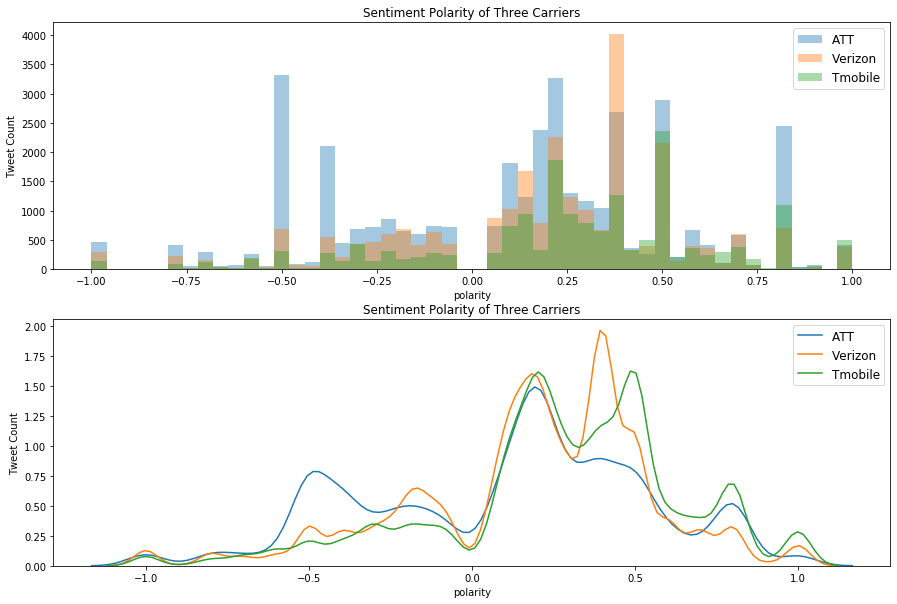

In [30]:
import seaborn as sns

plt.figure(figsize=(15,10))
plt.subplot(211)
data = att_df[(att_df.polarity >= 0.05) | (att_df.polarity <= -0.05)]
sns.distplot(data["polarity"], kde=False, hist=True, label="ATT")
data = verizon_df[(verizon_df.polarity >= 0.05) | (verizon_df.polarity <= -0.05)]
sns.distplot(data["polarity"], kde=False, hist=True, label="Verizon")
data = tmobile_df[(tmobile_df.polarity >= 0.05) | (tmobile_df.polarity <= -0.05)]
sns.distplot(data["polarity"], kde=False, hist=True, label="Tmobile")
plt.legend(prop={"size": 12})
plt.title("Sentiment Polarity of Three Carriers")
plt.ylabel("Tweet Count")

plt.subplot(212)
data = att_df[(att_df.polarity >= 0.05) | (att_df.polarity <= -0.05)]
sns.distplot(data["polarity"], kde=True, hist=False, label="ATT")
data = verizon_df[(verizon_df.polarity >= 0.05) | (verizon_df.polarity <= -0.05)]
sns.distplot(data["polarity"], kde=True, hist=False, label="Verizon")
data = tmobile_df[(tmobile_df.polarity >= 0.05) | (tmobile_df.polarity <= -0.05)]
sns.distplot(data["polarity"], kde=True, hist=False, label="Tmobile")
plt.legend(prop={"size": 12})
plt.title("Sentiment Polarity of Three Carriers")
plt.ylabel("Tweet Count")

plt.show()

### b. Overall sentiments polarity for each carrier

In [31]:
# Overall Sentiment Analysis using TextBlob

carrier = ['ATT', 'Verizon', 'Tmobile']
sentiment = []

for df in (att_df, verizon_df, tmobile_df):
    data = TextBlob(' '.join(df['clean_text'].values)).sentiment.polarity
    sentiment.append(data)


data = pd.DataFrame({'carrier':carrier, 'sentiment':sentiment})

data

,carrier,sentiment
0,ATT,0.086422
1,Verizon,0.152118
2,Tmobile,0.246736


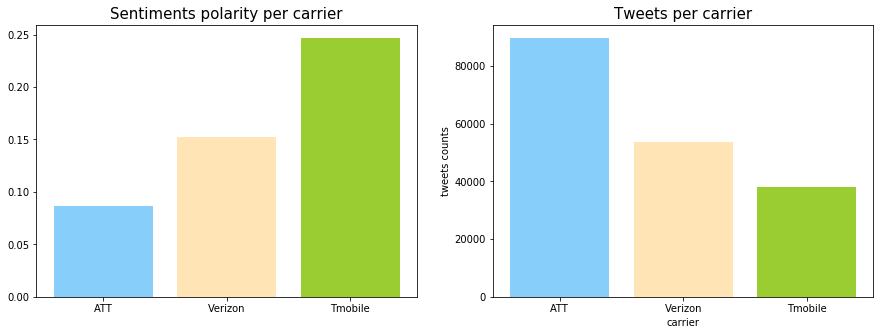

In [32]:
plt.figure(figsize=(15,5))
plt.subplot(121)
plt.bar(data['carrier'], data['sentiment'],color=['lightskyblue','moccasin','yellowgreen'])
plt.title('Sentiments polarity per carrier', fontsize=15)

plt.subplot(122)
plt.bar(carrier, carrier_counts, color=['lightskyblue','moccasin','yellowgreen'])
plt.xlabel('carrier')
plt.ylabel('tweets counts')
plt.title('Tweets per carrier', fontsize=15)
plt.show()

### Interpretation:

There is a interesting point that ATT has the most tweets, but get the worst polarity from users. And with the carrier tweets increaseing, the sentiment polarity is decreasing. 

### c. Positve VS. Negative Tweets percentage for 3 carriers

In [33]:
carrier = ['ATT', 'Verizon', 'Tmobile']
negative_counts = []
positive_counts = []

for df in (att_df, verizon_df, tmobile_df):
    counts = len(df[df.polarity < 0])
    negative_counts.append(counts)
    counts = len(df[df.polarity > 0])
    positive_counts.append(counts)


data = pd.DataFrame({'carrier':carrier, 'negative':negative_counts, 'positive':positive_counts})
data['percentage_negative'] = data['negative']/(data['negative']+data['positive'])
data['percentage_positive'] = data['positive']/(data['negative']+data['positive'])
data

,carrier,negative,positive,percentage_negative,percentage_positive
0,ATT,13167,24642,0.348250,0.651750
1,Verizon,6620,19717,0.251357,0.748643
2,Tmobile,3353,14547,0.187318,0.812682


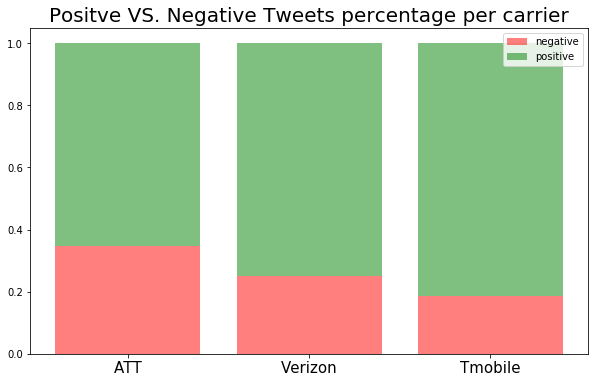

In [34]:
plt.figure(figsize=(10,6))
p1 = plt.bar(data['carrier'], data['percentage_negative'], color='r',label='negative',alpha=0.5)
p2 = plt.bar(data['carrier'], data['percentage_positive'], bottom=data['percentage_negative'], color='g', label='positive',alpha=0.5)
plt.legend()
plt.xticks(fontsize=15)
plt.title('Positve VS. Negative Tweets percentage per carrier', fontsize=20)
plt.show()

### Interpretation:

From this graph, we can explain the previous experiment that carrier with more tweets get lower polarity scores. That is because ATT has the most negative reviews ratio.

## Q5. Representative vocabulary in both Positve Tweets and Negative Tweets

### Method1: Most frequent words

In [35]:
# Frequent positive words for each carrier

att_positive_common_words = get5CommonWords(' '.join(att_df[att_df['sentiment']=='pos']['clean_text'].values))
tmobile_positive_common_words = get5CommonWords(' '.join(tmobile_df[tmobile_df['sentiment']=='pos']['clean_text'].values))
verizon_positive_common_words = get5CommonWords(' '.join(verizon_df[verizon_df['sentiment']=='pos']['clean_text'].values))

print(att_positive_common_words)
print(verizon_positive_common_words)
print(tmobile_positive_common_words)

[('help', 2918), ('thanks', 2431), ('live', 2301), ('first', 2273), ('love', 2177)]
[('free', 4006), ('disney', 3376), ('customer', 3167), ('year', 2799), ('new', 2238)]
[('love', 2157), ('thanks', 1306), ('new', 1271), ('want', 961), ('best', 867)]


In [36]:
# Frequent negative words for each carrier

att_negative_common_words = get5CommonWords(' '.join(att_df[att_df['sentiment']=='neg']['clean_text'].values))
tmobile_negative_common_words = get5CommonWords(' '.join(tmobile_df[tmobile_df['sentiment']=='neg']['clean_text'].values))
verizon_negative_common_words = get5CommonWords(' '.join(verizon_df[verizon_df['sentiment']=='neg']['clean_text'].values))

print(att_negative_common_words)
print(verizon_negative_common_words)
print(tmobile_negative_common_words)

[('customer', 2742), ('like', 2387), ('tweet', 2344), ('sent', 2144), ('email', 2143)]
[('service', 941), ('black', 571), ('phone', 559), ('galaxy', 441), ('samsung', 386)]
[('customer', 441), ('service', 378), ('ticket', 294), ('even', 277), ('phone', 256)]


In [37]:
def getfrequentWords(carrier, common_words):
    word,count = zip(*common_words)
    print(carrier,' : ',', '.join(word))

getfrequentWords('ATT -- Pos', att_positive_common_words)
getfrequentWords('ATT -- Neg', att_negative_common_words)
print('----------')
getfrequentWords('Verizon -- Pos', verizon_positive_common_words)
getfrequentWords('Verizon -- Neg', verizon_negative_common_words)
print('----------')
getfrequentWords('Tmobile -- Pos', tmobile_positive_common_words)
getfrequentWords('Tmobile -- Pos', tmobile_negative_common_words)

ATT -- Pos  :  help, thanks, live, first, love
ATT -- Neg  :  customer, like, tweet, sent, email
----------
Verizon -- Pos  :  free, disney, customer, year, new
Verizon -- Neg  :  service, black, phone, galaxy, samsung
----------
Tmobile -- Pos  :  love, thanks, new, want, best
Tmobile -- Pos  :  customer, service, ticket, even, phone


### Method2: Get representative words by Topic Modeling

In [109]:
from gensim.corpora import Dictionary
from gensim.models import LdaModel, LdaMulticore
from gensim.models import TfidfModel
import nltk

In [110]:
# Convert to list
def topicKeywords(df):
    tokens = []
    for i, row in df.iterrows():
        text = row["clean_text"]
        words = text.split()
        words = [w for w in words if w.isalpha() and len(w)>2]
        # only screen out NOUN words
        uni_pos = nltk.pos_tag(words, tagset='universal')
        words = [w[0] for w in uni_pos if w[1]=='NOUN']
        tokens.append(words)

    my_dict = Dictionary(tokens)
    my_dict.filter_extremes(no_below=5, no_above=0.85)
   
    # Count Vectorization
    dtm = [my_dict.doc2bow(doc) for doc in tokens]
    
    # TF-IDF Vectorization
    tfidf = TfidfModel(dtm)
    tfidf = tfidf[dtm]

    lda_model = LdaModel(tfidf, num_topics=5, id2word=my_dict, passes=10)
    return lda_model
    

In [111]:
carrier_df = (att_df, verizon_df, tmobile_df)
sentiment = ['pos', 'neg']

for d in carrier_df:
    for s in sentiment:
        model = topicKeywords(d[d['sentiment']==s])
        print(d.carrier.values[0], '-', s)
        for i in range(5):
            wp = model.show_topic(i)
            topic_keywords = ", ".join([word for word, prop in wp])
            print('Topic',i+1, ': ', topic_keywords)
        print('----------')
        

att - pos
Topic 1 :  day, customer, reply, thing, time, wifi, year, work, att, service
Topic 2 :  josh, att, career, total, attempt, thank, part, call, chance, post
Topic 3 :  thanks, look, help, bill, phone, service, please, account, internet, people
Topic 4 :  love, today, week, ticket, month, right, hand, fee, man, sunday
Topic 5 :  episode, mini, series, offseason, court, star, player, lol, interview, http
----------
att - neg
Topic 1 :  cause, tweet, concert, celebrate, tomorro, city, idea, life, towards, att
Topic 2 :  game, help, everyone, employee, acc, vote, account, please, get, see
Topic 3 :  people, fuck, game, att, trump, mean, look, company, news, night
Topic 4 :  service, att, time, day, phone, hate, others, hour, internet, customer
Topic 5 :  board, member, stephenson, sent, thousand, samuel, email, customer, ticket, shit
----------
verizon - pos
Topic 1 :  phone, note, service, issue, area, thank, verizon, network, cable, data
Topic 2 :  thanks, work, bill, day, reward

### Interpretation:

The topic modeling method should be better, because the term frequency of BOW model only considers the frequently appearing words in one total domain. However, the most common words are not necessarily representative. Topic modeling is good for dividing the text set into several topics, and these topics can represent several major themes that users love and complain about.

In [222]:
df.location.value_counts()

                                  75811
Bellevue, WA                       4599
United States                      4390
New York, NY                       1856
Dallas, TX                         1669
USA                                1640
Los Angeles, CA                    1527
California, USA                    1440
Texas, USA                         1084
Florida, USA                       1078
Chicago, IL                        1014
Houston, TX                         985
Atlanta, GA                         943
Washington, DC                      908
New York, USA                       773
Knoxville, TN                       719
New Jersey, USA                     660
New York                            648
Brooklyn, NY                        579
Seattle, WA                         564
San Francisco, CA                   525
Miami, FL                           506
Rapid City, SD--Black Hills         498
Pennsylvania, USA                   498
Las Vegas, NV                       485


### Interpretation:

According to the location data, we can notice it is very messy. Some refer to the country, some refer to the state, and some refer to the city. Therefore, we think it is not worth to explore in depth.